In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
file_path = '/content/drive/MyDrive/household_power_consumption.txt'

df = pd.read_csv(
    file_path,
    sep=';',
    parse_dates={'Datetime': ['Date', 'Time']},
    infer_datetime_format=True,
    na_values='?',
    low_memory=False
)

df.set_index('Datetime', inplace=True)

print(df.head())
print(df.info())


/tmp/ipython-input-2223892177.py:8: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/tmp/ipython-input-2223892177.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

/tmp/ipython-input-2223892177.py:8: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


/tmp/ipython-input-260199914.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  power = power.fillna(method='ffill')


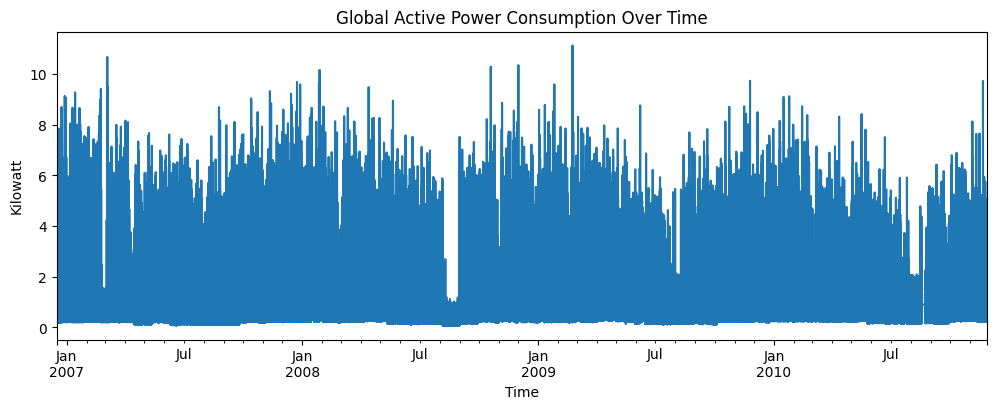

In [ ]:
power = df['Global_active_power']

# Forward fill missing values
power = power.fillna(method='ffill')

power.plot(figsize=(12,4))
plt.title("Global Active Power Consumption Over Time")
plt.ylabel("Kilowatt")
plt.xlabel("Time")
plt.show()


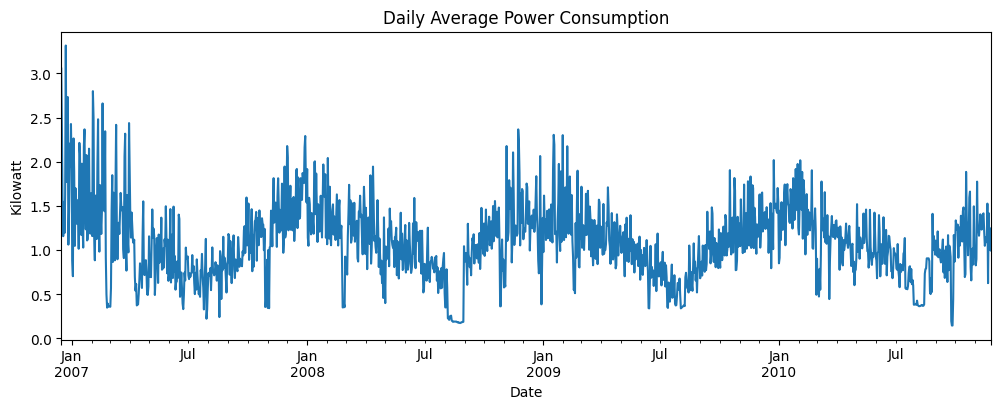

In [ ]:
daily_power = power.resample('D').mean()

daily_power.plot(figsize=(12,4))
plt.title("Daily Average Power Consumption")
plt.ylabel("Kilowatt")
plt.xlabel("Date")
plt.show()


Train–Test Split (Time-Series way)
We’ll use:

Train: first 80%

Test: last 20%

In [ ]:
# Train-test split (80-20)
train_size = int(len(daily_power) * 0.8)

train = daily_power[:train_size]
test = daily_power[train_size:]

print("Train size:", train.shape)
print("Test size:", test.shape)


Train size: (1153,)
Test size: (289,)


training

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),  # weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit(disp=False)

print(sarima_result.summary())


                                     SARIMAX Results                                     
Dep. Variable:               Global_active_power   No. Observations:                 1153
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -221.398
Date:                           Thu, 01 Jan 2026   AIC                            452.796
Time:                                   17:40:52   BIC                            477.972
Sample:                               12-16-2006   HQIC                           462.305
                                    - 02-10-2010                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2589      0.027      9.709      0.000       0.207       0.311
ma.L1         -0.8714      0.015    -56.446

Forecast on Test Data

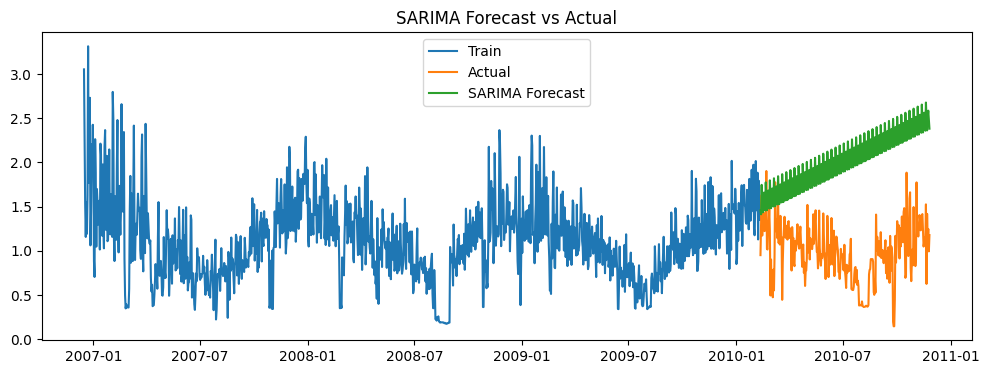

In [ ]:
# Forecast
forecast = sarima_result.forecast(steps=len(test))

# Plot comparison
plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='SARIMA Forecast')
plt.legend()
plt.title("SARIMA Forecast vs Actual")
plt.show()


Evaluation Metrics

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)

print("SARIMA MAE :", mae)
print("SARIMA RMSE:", rmse)
print("SARIMA MAPE:", mape, "%")


SARIMA MAE : 1.0473408503733241
SARIMA RMSE: 1.1363395885362861
SARIMA MAPE: 144.47414836567324 %


Feature Engineering for Random Forest

In [ ]:
# Create supervised dataset (lag features)
def create_lag_features(series, lags=7):
    df = pd.DataFrame(series)
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df[series.name].shift(i)
    df.dropna(inplace=True)
    return df

rf_data = create_lag_features(daily_power, lags=7)

X = rf_data.drop(columns=['Global_active_power'])
y = rf_data['Global_active_power']

# Train-test split (same 80-20)
split = int(len(X) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


Train Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1,
                      random_state=42)

Predict & Evaluate

In [ ]:
# Make sure RF uses tabular (2D) data, not LSTM data
X_test_rf = X_test.copy() if len(X_test.shape) == 2 else X_test.reshape(X_test.shape[0], -1)


In [ ]:
# Recreate RF test data (2D)
X_test_rf = rf_data.drop(columns=['Global_active_power']).iloc[split:]
y_test_rf = rf_data['Global_active_power'].iloc[split:]

# Predict
rf_pred = rf_model.predict(X_test_rf)

# Metrics
rf_mae = mean_absolute_error(y_test_rf, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test_rf, rf_pred))
rf_mape = mean_absolute_percentage_error(y_test_rf, rf_pred)

print("Random Forest MAE :", rf_mae)
print("Random Forest RMSE:", rf_rmse)
print("Random Forest MAPE:", rf_mape, "%")


Random Forest MAE : 0.18267832793108088
Random Forest RMSE: 0.2449217580458639
Random Forest MAPE: 23.48476103711758 %


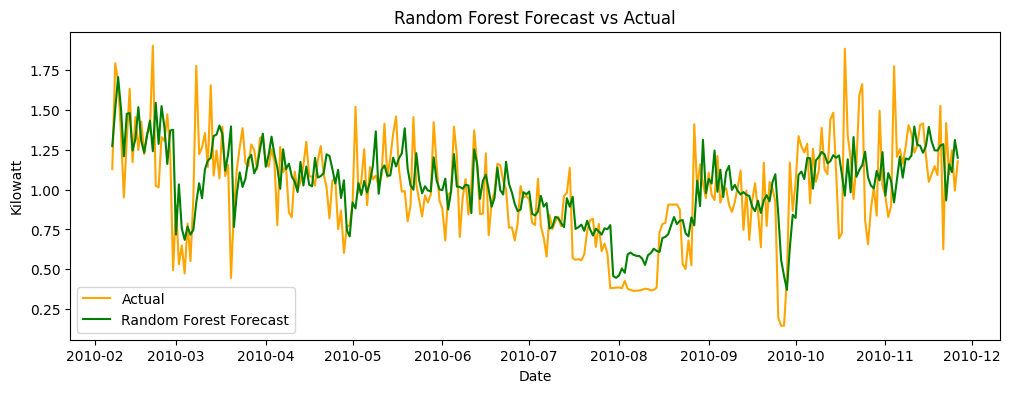

In [ ]:
rf_test_index = daily_power.index[split + 7:]  # +7 because of lag features
plt.figure(figsize=(12,4))

plt.plot(rf_test_index, y_test_rf, label="Actual", color="orange")
plt.plot(rf_test_index, rf_pred, label="Random Forest Forecast", color="green")

plt.title("Random Forest Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Kilowatt")
plt.legend()
plt.show()


Prepare Data for LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_power = scaler.fit_transform(daily_power.values.reshape(-1,1))

def create_sequences(data, seq_length=14):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(scaled_power, seq_length=14)

# Train-test split
split = int(len(X_lstm) * 0.8)
X_train, X_test = X_lstm[:split], X_lstm[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]


Build LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='tanh', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Train LSTM

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0530 - val_loss: 0.0126
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115 - val_loss: 0.0083
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0110 - val_loss: 0.0079
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0124 - val_loss: 0.0087
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0104 - val_loss: 0.0086
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0118 - val_loss: 0.0080
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0107 - val_loss: 0.0079
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0110 - val_loss: 0.0079
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0106 - val_loss: 0.0084
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0104 - val_loss: 0.0081
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0098 - val_l

Predict & Evaluate LSTM

In [ ]:
lstm_pred = model.predict(X_test)

# Inverse scaling
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_inv = scaler.inverse_transform(y_test)

lstm_mae = mean_absolute_error(y_test_inv, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_pred))
lstm_mape = mean_absolute_percentage_error(y_test_inv, lstm_pred)

print("LSTM MAE :", lstm_mae)
print("LSTM RMSE:", lstm_rmse)
print("LSTM MAPE:", lstm_mape, "%")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM MAE : 0.18657445953070936
LSTM RMSE: 0.25039277625672557
LSTM MAPE: 25.34039974620924 %


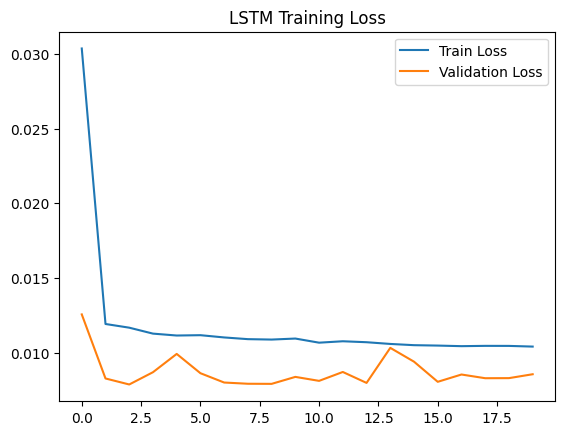

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("LSTM Training Loss")
plt.show()


In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [ ]:
lstm_test_index = daily_power.index[-len(y_test_inv):]


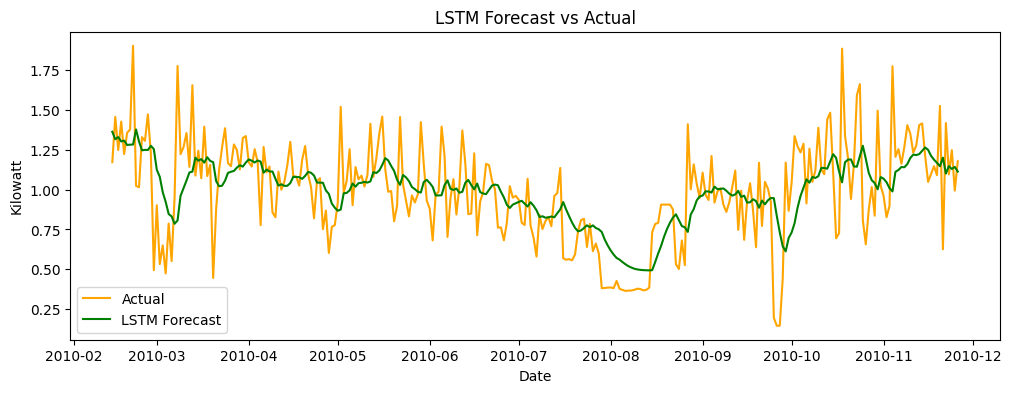

In [ ]:
plt.figure(figsize=(12,4))

plt.plot(lstm_test_index, y_test_inv, label="Actual", color="orange")
plt.plot(lstm_test_index, lstm_pred, label="LSTM Forecast", color="green")

plt.title("LSTM Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Kilowatt")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Models
models = ['SARIMA', 'Random Forest', 'LSTM']

# Evaluation metrics (from your experiments)
mae_values  = [1.0473, 0.1827, 0.1866]
rmse_values = [1.1363, 0.2449, 0.2504]
mape_values = [144.47, 23.48, 25.34]


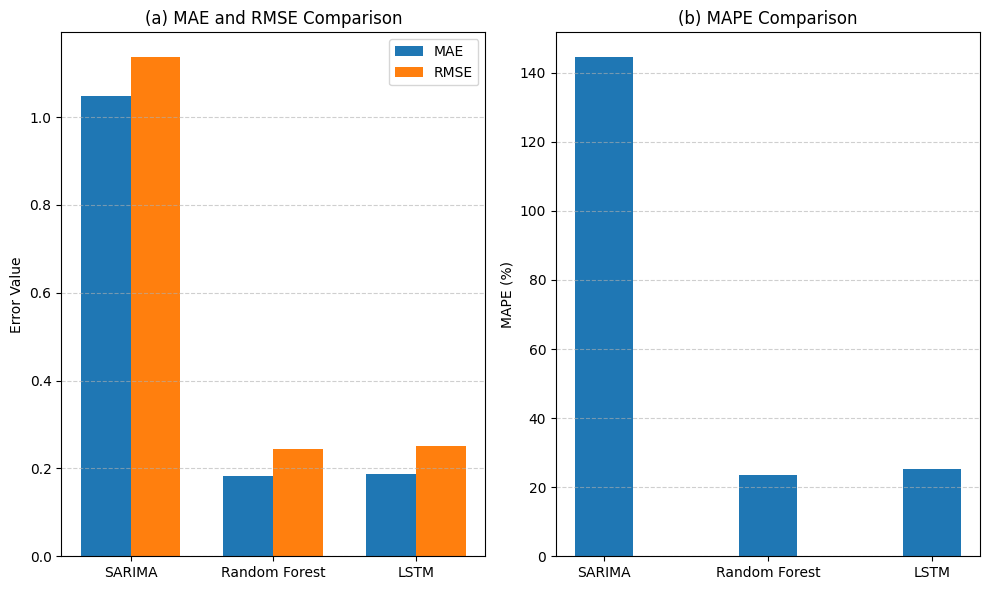

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['SARIMA', 'Random Forest', 'LSTM']

mae = [1.0473, 0.1827, 0.1866]
rmse = [1.1363, 0.2449, 0.2504]
mape = [144.47, 23.48, 25.34]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))

# -------- Subplot 1: MAE & RMSE --------
plt.subplot(1, 2, 1)
plt.bar(x - width/2, mae, width, label='MAE')
plt.bar(x + width/2, rmse, width, label='RMSE')

plt.xticks(x, models)
plt.ylabel('Error Value')
plt.title('(a) MAE and RMSE Comparison')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# -------- Subplot 2: MAPE --------
plt.subplot(1, 2, 2)
plt.bar(x, mape, width, label='MAPE')

plt.xticks(x, models)
plt.ylabel('MAPE (%)')
plt.title('(b) MAPE Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
